In [4]:
import sys
sys.path.append('..')
from postgresql import Postgresql

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot # 自相关图
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf 

/home/zt/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [6]:
config = {'host':'localhost', 'port':5432, 'user':'postgres', 'password':'postgres', 'database':'zhoutao'}
postgre = Postgresql(config)
haikang = postgre.selectSql("select name_stock, yesterday_close_price,open_price, high_price, low_price, close_price, transaction_stocks, transaction_price, datetime_stock from stocks_sh_sz where code_stock = '002415.SZ'")

In [7]:
haikang_pd = pd.DataFrame(np.array(haikang),columns=["name_stock", "yesterday_close_price","open_price", "high_price", "low_price", "close_price", "transaction_stocks", "transaction_price", "datetime_stock"])

# 收盘价

In [8]:
haikang_pd = haikang_pd.set_index('datetime_stock')

In [9]:
haikang_pd.head()

,name_stock,yesterday_close_price,open_price,high_price,low_price,close_price,transaction_stocks,transaction_price
datetime_stock,,,,,,,,
2010-05-28,海康威视,-99,6.0044,6.3893,5.9182,6.307,34098354,2.7237e+09
2010-05-31,海康威视,6.307,6.611,6.7565,6.4286,6.5433,17227873,1.47129e+09
2010-06-01,海康威视,6.5433,6.6203,6.7742,6.4802,6.7165,10994680,9.4544e+08
2010-06-02,海康威视,6.7165,6.5048,6.6511,6.3293,6.628,9496264,8.0074e+08
2010-06-03,海康威视,6.628,6.6203,6.6811,6.2362,6.2816,7560522,6.35492e+08


In [10]:
haikang_pd.tail()

,name_stock,yesterday_close_price,open_price,high_price,low_price,close_price,transaction_stocks,transaction_price
datetime_stock,,,,,,,,
2016-06-02,海康威视,21.15,21.15,21.18,20.7,20.96,15953570,3.33961e+08
2016-06-03,海康威视,20.96,20.95,21.56,20.87,21.38,19921524,4.23014e+08
2016-06-06,海康威视,21.38,21.37,21.46,21.08,21.17,17959680,3.81337e+08
2016-06-07,海康威视,21.17,21.17,21.29,21.03,21.13,15267867,3.22786e+08
2016-06-08,海康威视,21.13,21.12,21.19,20.96,21,17074065,3.59548e+08


# 1 数据预处理

In [11]:
def stationarity(timeseries):    
    """
    检验数据的平稳性
    """
    # 移动平均
    rolmean = timeseries.rolling(window=20, center=False).mean()
    rolstd = timeseries.rolling(window=20, center=False).std()

    #Plot rolling statistics:
    plt.figure(figsize=(30, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','10_day_volatility', '50_day_moving_avg'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

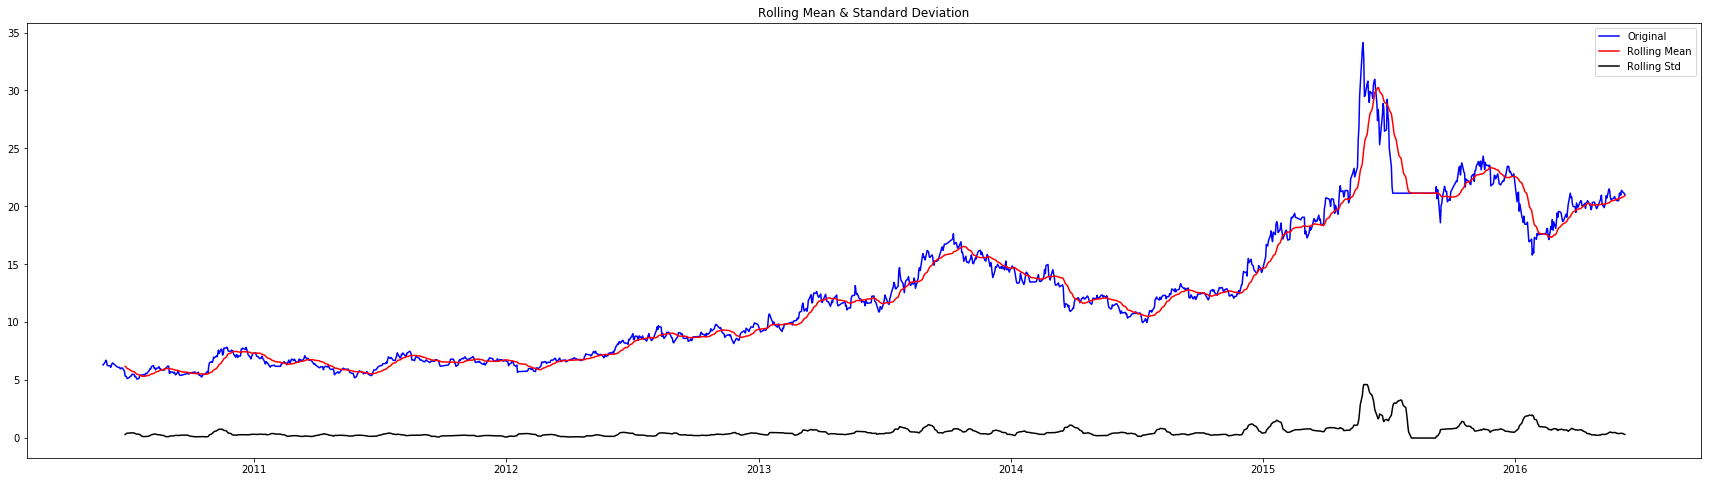

Results of Dickey-Fuller Test:
Test Statistic            -1.121736
p-value                    0.706326
10_day_volatility         23.000000
50_day_moving_avg       1441.000000
Critical Value (1%)       -3.434896
Critical Value (5%)       -2.863548
Critical Value (10%)      -2.567839
dtype: float64


In [12]:
stationarity(haikang_pd['close_price'])

## 1.1 数据平稳

严平稳的条件只是理论上的存在，现实中用得比较多的是宽平稳的条件。

宽平稳也叫弱平稳或者二阶平稳（均值和方差平稳），它应满足：

常数均值
常数方差
常数自协方差
平稳性检验：观察法和单位根检验法

观察法，通俗的说就是通过观察序列的趋势图与相关图是否随着时间的变化呈现出某种规律。所谓的规律就是时间序列经常提到的周期性因素，现实中遇到得比较多的是线性周期成分，这类周期成分可以采用差分或者移动平均来解决，而对于非线性周期成分的处理相对比较复杂，需要采用某些分解的方法。下图为航空数据的线性图，可以明显的看出它具有年周期成分和长期趋势成分。平稳序列的自相关系数会快速衰减，下面的自相关图并不能体现出该特征，所以我们有理由相信该序列是不平稳的

单位根检验：ADF是一种常用的单位根检验方法，他的原假设为序列具有单位根，即非平稳，对于一个平稳的时序数据，就需要在给定的置信水平上显著，拒绝原假设。ADF只是单位根检验的方法之一，如果想采用其他检验方法，可以安装第三方包arch，里面提供了更加全面的单位根检验方法，个人还是比较钟情ADF检验。以下为检验结果，其p值大于0.99，说明并不能拒绝原假设。

### 1.1.1 取对数

对数变换主要是为了减小数据的振动幅度，使其线性规律更加明显（我是这么理解的时间序列模型大部分都是线性的，为了尽量降低非线性的因素，需要对其进行预处理，也许我理解的不对）。对数变换相当于增加了一个惩罚机制，数据越大其惩罚越大，数据越小惩罚越小。这里强调一下，变换的序列需要满足大于0，小于0的数据不存在对数变换。

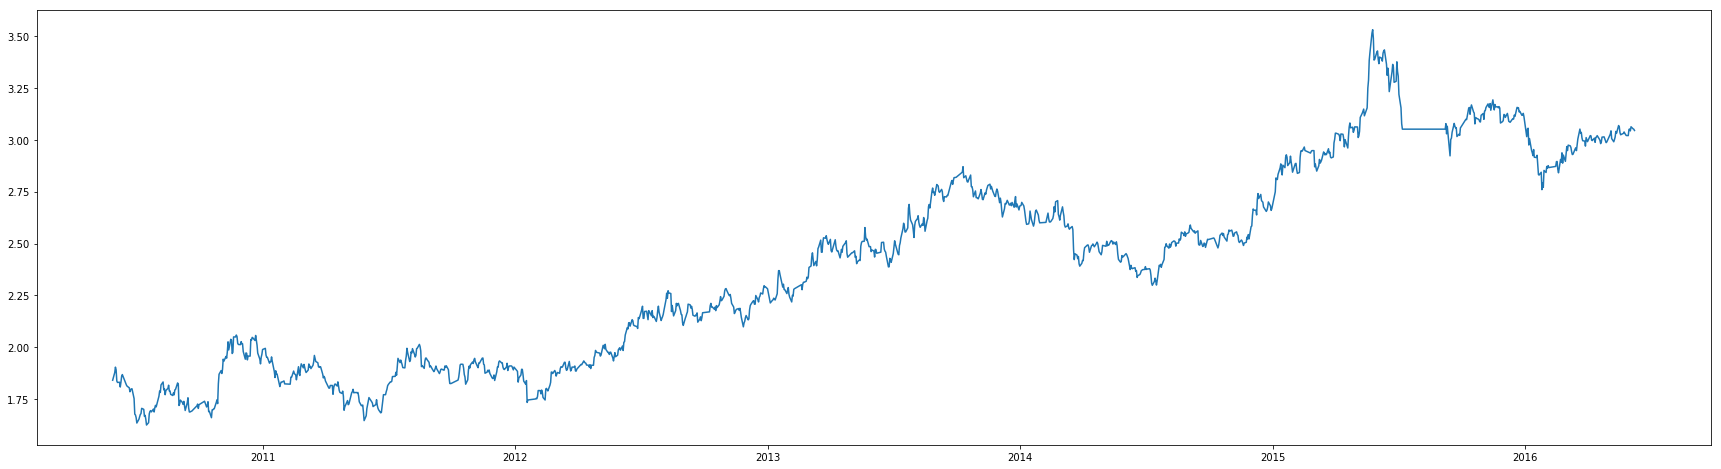

In [13]:
ts_log = np.log(np.asarray(haikang_pd['close_price'], dtype=float))
ts_log = pd.Series(ts_log, index=haikang_pd.index)
plt.figure(figsize=(30, 8))
plt.plot(ts_log)

### 1.1.2 滑动平均

根据平滑技术的不同，平滑法具体分为移动平均法和指数平均法。

移动平均即利用一定时间间隔内的平均值作为某一期的估计值，而指数平均则是用变权的方法来计算均值

指数平均法是对周期内的数据进行了加权，能在一定程度上减小年周期因素，但并不能完全剔除，如要完全剔除可以进一步进行差分操作

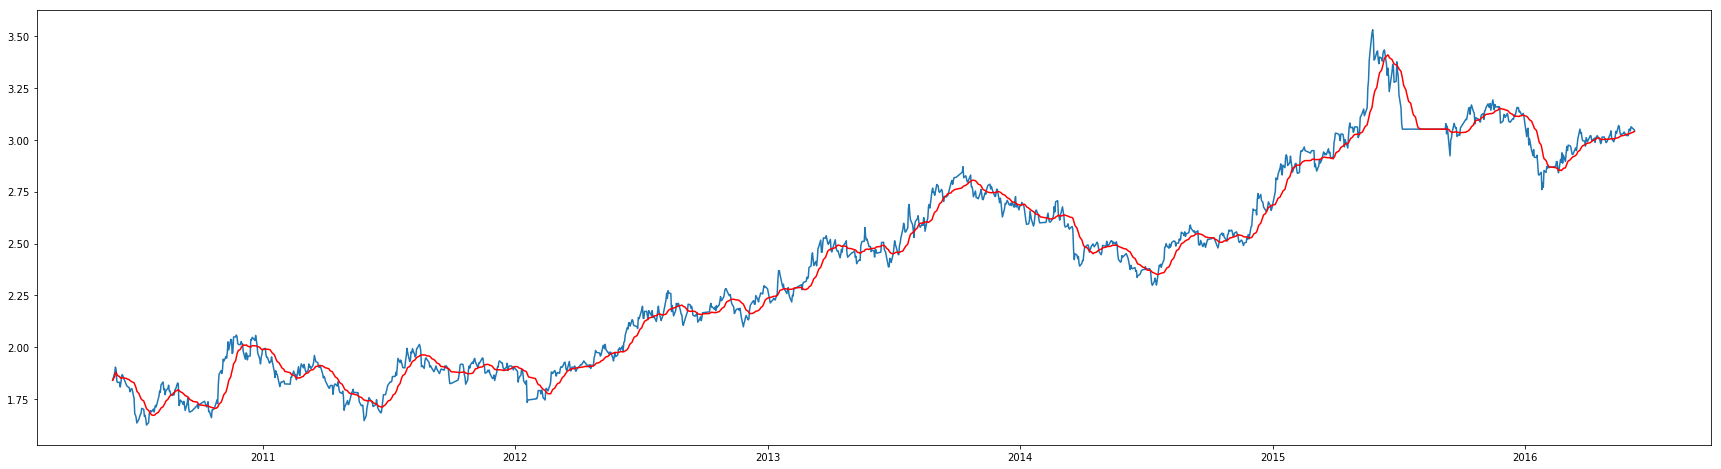

In [14]:
# 对取对数之后的序列,进行滑动平均
moving_avg = pd.Series(ts_log).rolling(window=20, center=False, min_periods=1).mean()
plt.figure(figsize=(30, 8))
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

### 1.1.3 差分,排除趋势和季节性

时间序列最常用来剔除周期性因素的方法当属差分了，它主要是对等周期间隔的数据进行线性求减。前面我们说过，ARIMA模型相对ARMA模型，仅多了差分操作，ARIMA模型几乎是所有时间序列软件都支持的，差分的实现与还原都非常方便。

ARIMA模型相对ARMA模型，仅多了差分操作。而statsmodel中，对差分的支持不是很好，它不支持高阶和多阶差分

可以先用pandas将序列差分好，然后在对差分好的序列进行ARIMA拟合

In [15]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)

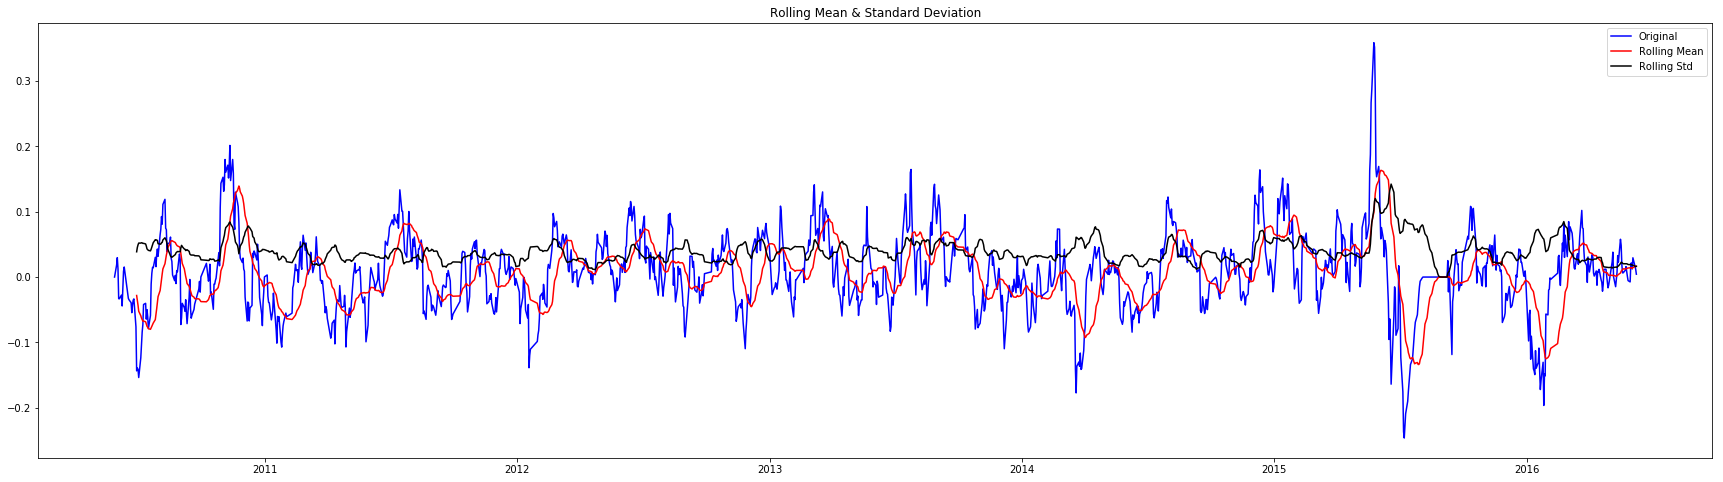

Results of Dickey-Fuller Test:
Test Statistic         -6.803088e+00
p-value                 2.211484e-09
10_day_volatility       2.400000e+01
50_day_moving_avg       1.440000e+03
Critical Value (1%)    -3.434899e+00
Critical Value (5%)    -2.863549e+00
Critical Value (10%)   -2.567840e+00
dtype: float64


In [16]:
# 对差分后的序列进行检验
stationarity(ts_log_moving_avg_diff)


1. DataFrame.shift(periods=1, freq=None, axis=0)

    periods：类型为int，表示移动的幅度，可以是正数，也可以是负数，默认值是1,1就表示移动一次，注意这里移动的都是数据，而索引是不移动的，移动之后没有对应值的，就赋值为NaN

2. shift(periods=1,freq=datetime.timedelta(1))
    
    freq： DateOffset, timedelta, or time rule string，可选参数，默认值为None，只适用于时间序列，如果这个参数存在，那么会按照参数值移动时间索引，而数据值没有发生变化
    axis：{0, 1, ‘index’, ‘columns’}，表示移动的方向，如果是0或者’index’表示上下移动，如果是1或者’columns’，则会左右移动。
    
3. diff函数和shift函数之间的关系
    df - df.diff(periods=2,axis=0) 等价 df.shift(periods=2,axis=0)

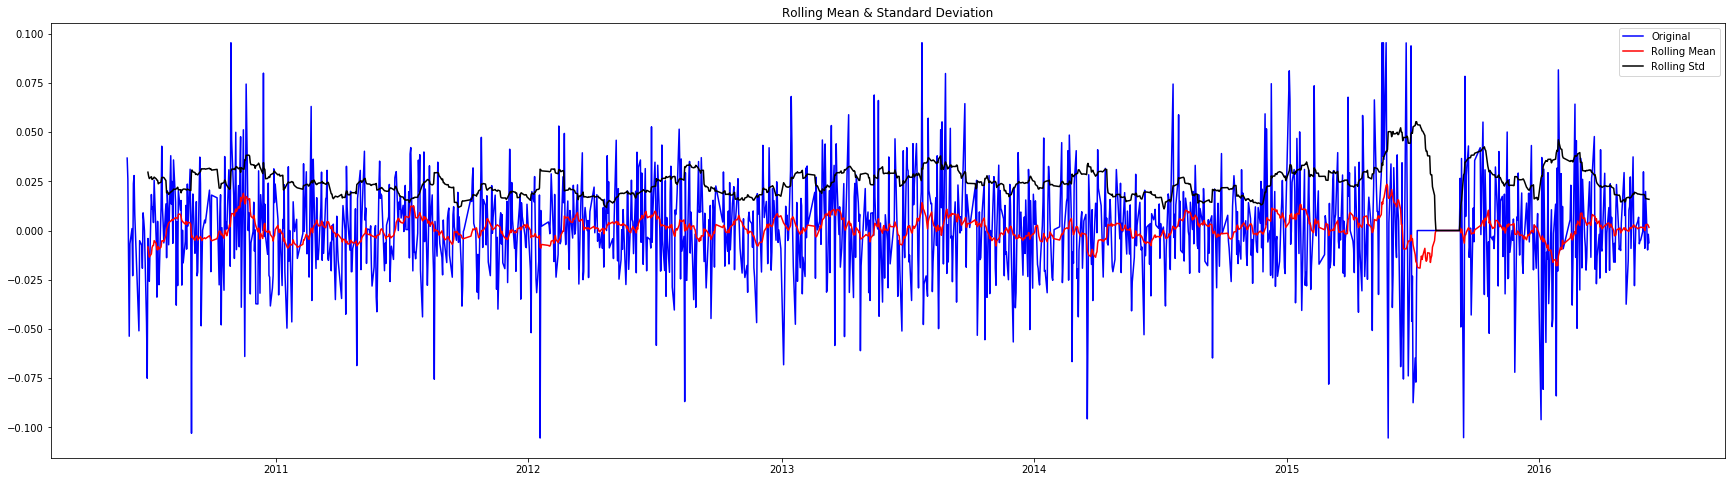

Results of Dickey-Fuller Test:
Test Statistic           -28.110521
p-value                    0.000000
10_day_volatility          1.000000
50_day_moving_avg       1462.000000
Critical Value (1%)       -3.434831
Critical Value (5%)       -2.863519
Critical Value (10%)      -2.567824
dtype: float64


In [17]:
ts_log_diff = ts_log - ts_log.shift()
ts_log_diff.dropna(inplace=True)
stationarity(ts_log_diff)

## 1.2 分解时间序列
将时序数据分离成不同的成分。statsmodels使用的X-11分解过程，它主要将时序数据分离成长期趋势、季节趋势和随机成分。

statsmodels也支持两类分解模型，加法模型和乘法模型，这里我只实现加法，乘法只需将model的参数设置为"multiplicative"即可。

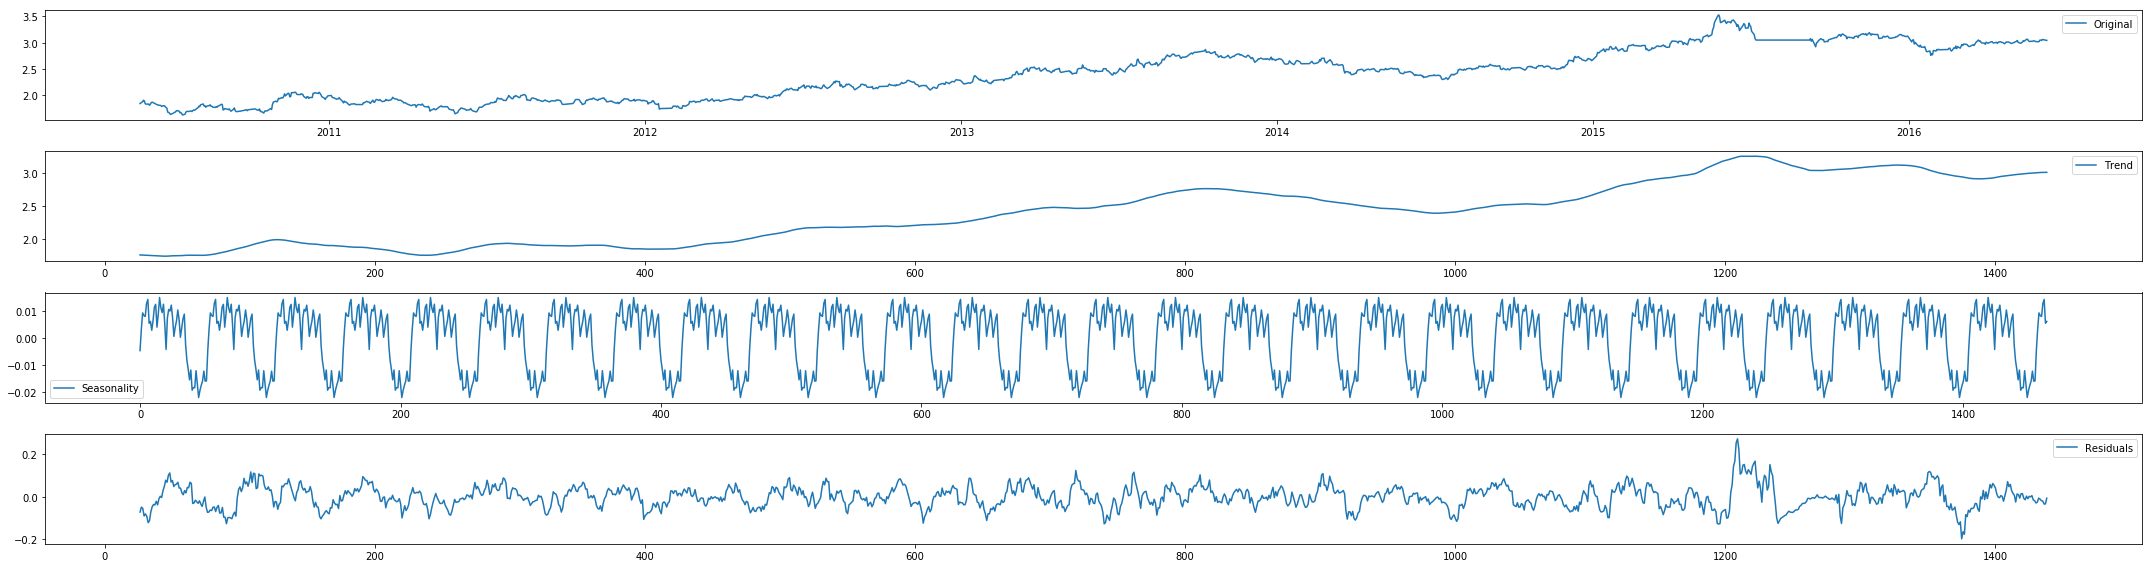

In [18]:
decomposition = seasonal_decompose(ts_log.values, freq=52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.figure(figsize=(30, 8))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

该序列具有明显的年周期与长期成分。对于年周期成分我们使用窗口为12的移动平进行处理，对于长期趋势成分我们采用1阶差分来进行处理。

查看分解之后的残差序列是否平稳

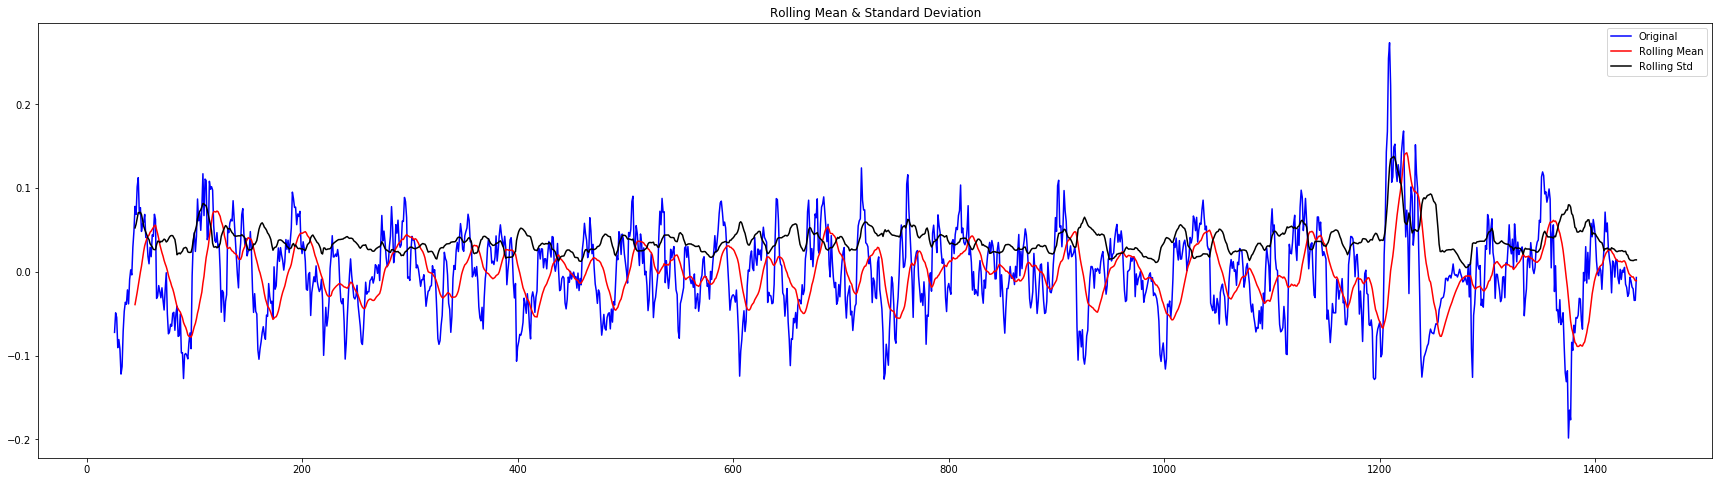

Results of Dickey-Fuller Test:
Test Statistic         -8.507223e+00
p-value                 1.193842e-13
10_day_volatility       2.300000e+01
50_day_moving_avg       1.389000e+03
Critical Value (1%)    -3.435067e+00
Critical Value (5%)    -2.863623e+00
Critical Value (10%)   -2.567879e+00
dtype: float64


In [19]:
ts_log_decompose = pd.Series(residual)
ts_log_decompose.dropna(inplace=True)
stationarity(ts_log_decompose)

## 2 自相关

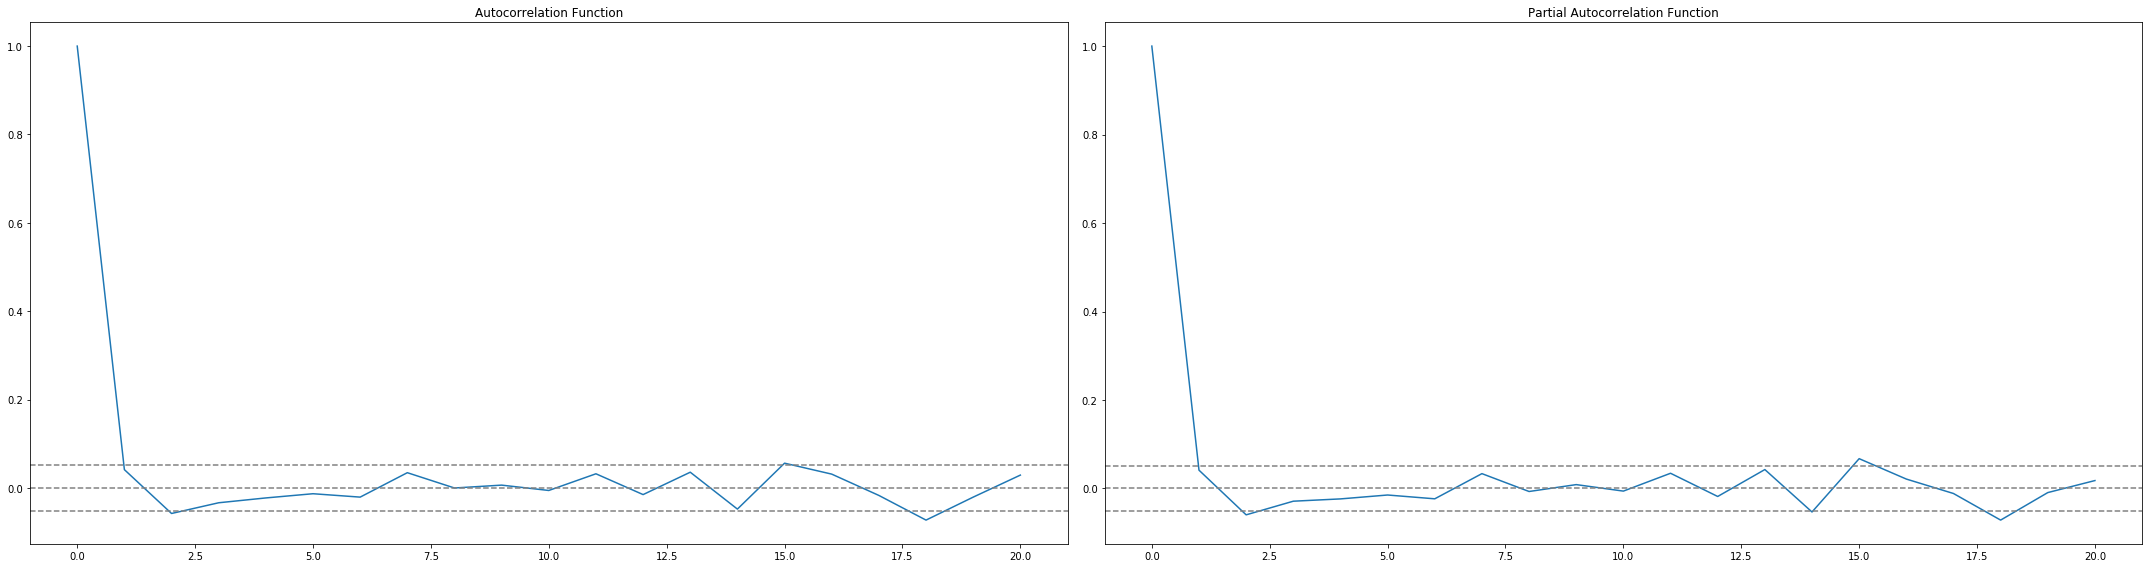

In [20]:
# 自相关ACF和偏相关图PACF，默认阶数为30阶
def plot_acf_pacf(ts_log_diff, nlags=20):
    # 计算ACF  PACF值
    lag_acf = acf(ts_log_diff, nlags=nlags)
    lag_pacf = pacf(ts_log_diff, nlags=nlags, method='ols')

    #Plot ACF: 
    plt.figure(figsize=(30, 8))
    plt.subplot(121)    
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

    #Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

# 通过时间分解之后,发现ts_log存在季节周期,和长期周期,所以对ts_log,进行移动平均,差分之后,得到ts_log_diff
plot_acf_pacf(ts_log_diff)

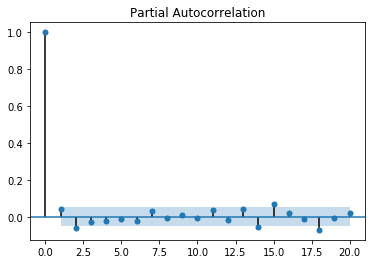

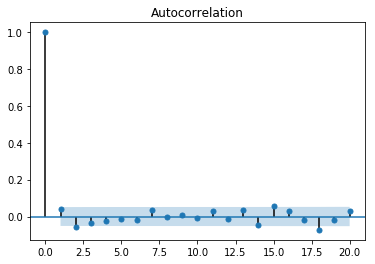

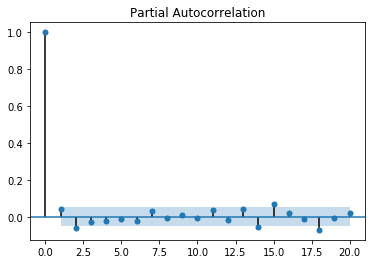

In [21]:
# 自相关ACF和偏相关图PACF画
plt.figure(figsize=(30, 8))

plot_acf(ts_log_diff, lags=20)

plot_pacf(ts_log_diff, lags=20, method='ols')

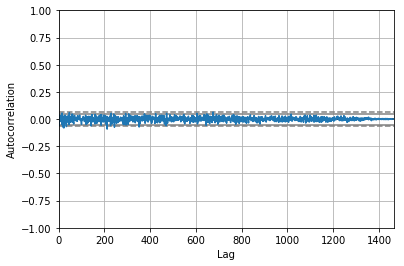

In [22]:
autocorrelation_plot(ts_log_diff)
plt.show()

# 3 ARIMA

## 3.1 AR

/home/zt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/zt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/home/zt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 0.9579')

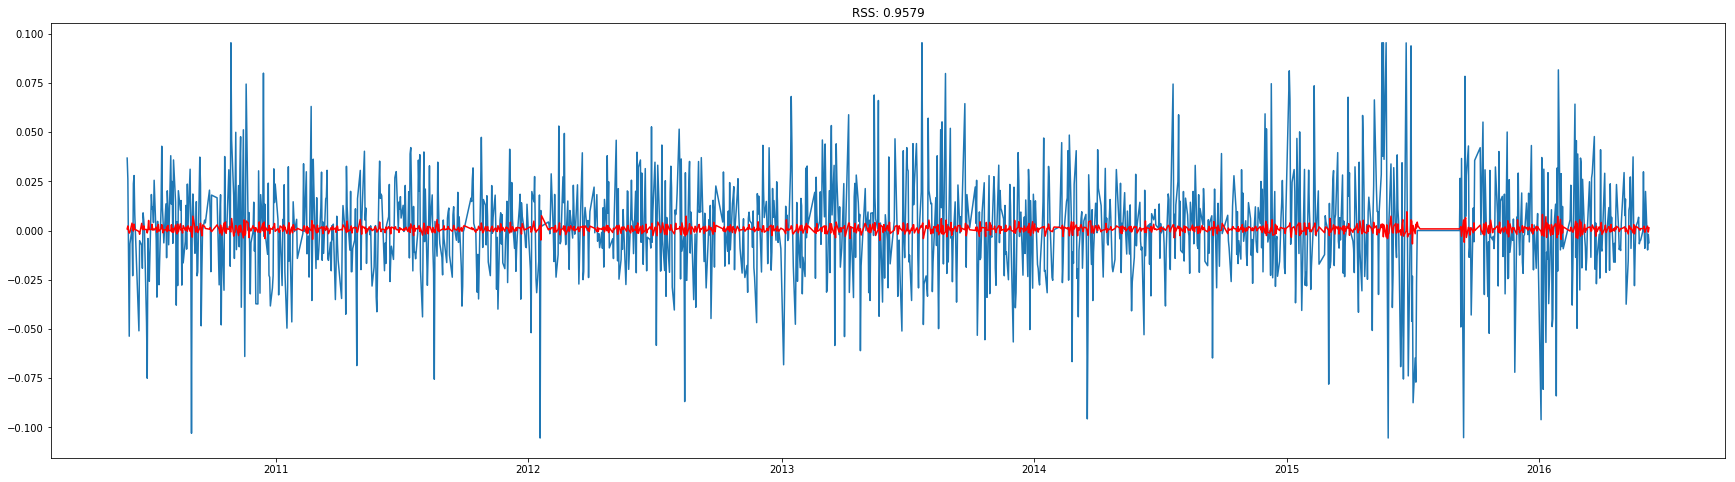

In [23]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)
plt.figure(figsize=(30, 8))
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

## 3.2 MA

/home/zt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/zt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/home/zt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS: 0.9580')

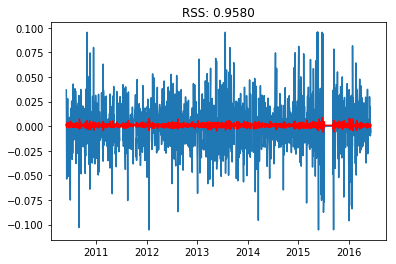

In [24]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

## 3.3 ARIMA

注意: statamodel只能提供1阶差分,所以order中的差分只能是1

/home/zt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/zt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/home/zt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RSS (Root Squared Sum): 0.9593')

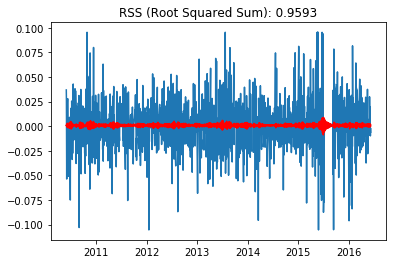

In [25]:
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS (Root Squared Sum): %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [26]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

datetime_stock
2010-05-31    0.000821
2010-06-01    0.001382
2010-06-02    0.000427
2010-06-03   -0.000387
2010-06-04    0.000703
dtype: float64


In [27]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

datetime_stock
2010-05-31    0.000821
2010-06-01    0.002203
2010-06-02    0.002630
2010-06-03    0.002243
2010-06-04    0.002945
dtype: float64


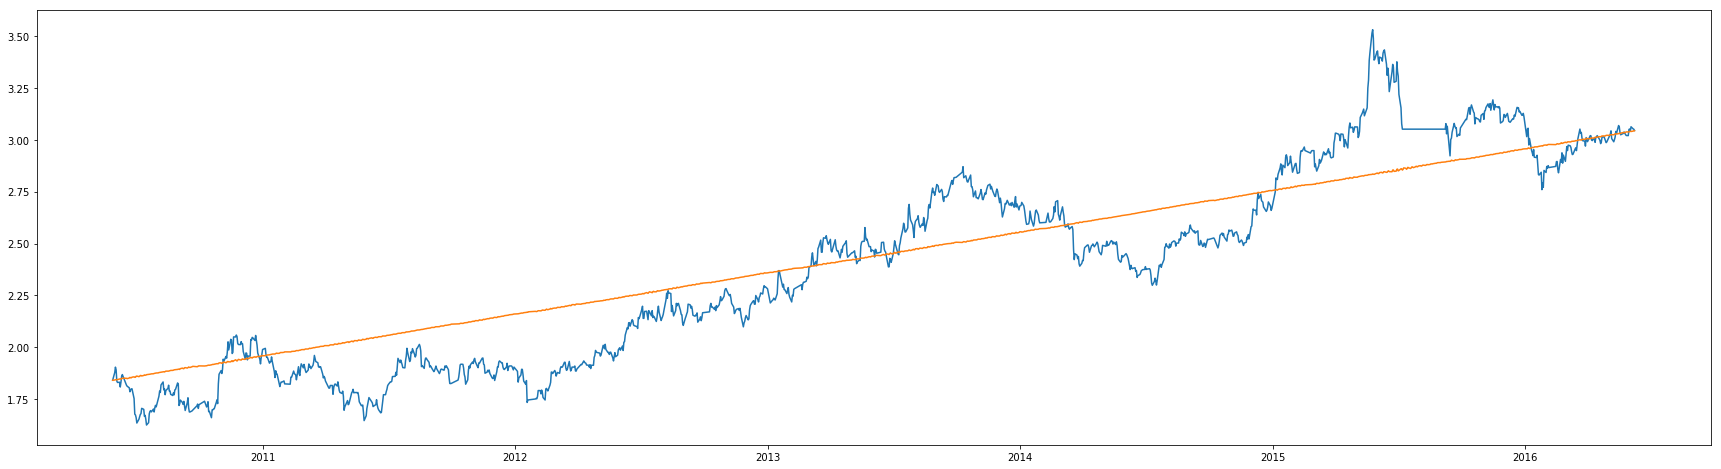

In [28]:
# pd.Series有add方法
predictions_ARIMA_log = pd.Series(pd.Series(ts_log).iloc[0], index=pd.Series(ts_log).index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()
plt.figure(figsize=(30, 8))
plt.plot(ts_log)
plt.plot(predictions_ARIMA_log)

Text(0.5,1,'RMSE: 10.5033')

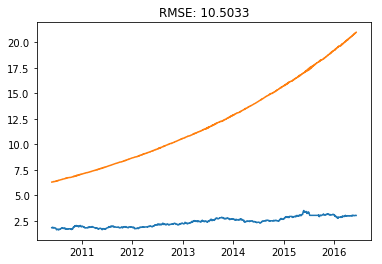

In [35]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_log)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts_log)**2)/len(ts_log)))

## 残差

###  残差的时间序列

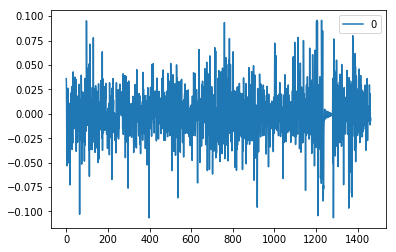

In [100]:
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot()
pyplot.show()

###  查看残差是否服从正太分布

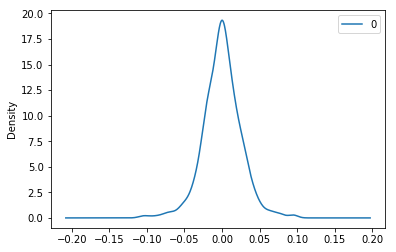

                  0
count  1.464000e+03
mean   7.929521e-07
std    2.560737e-02
min   -1.066660e-01
25%   -1.492090e-02
50%   -1.407997e-04
75%    1.444398e-02
max    9.576197e-02


In [101]:
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

# 4 样本拟合

模型拟合完后，我们就可以对其进行预测了。由于ARMA拟合的是经过相关预处理后的数据，故其预测值需要通过相关逆变换进行还原。
 
1. 因为results_ARIMA模型中,带入ARIMA模型中,ts_log只是原数据被log画,所以只需要反log
2. 如果带入ARIMA模型中,则ts_log_diff是被ts经过取对数,滑动,差分操作之后,要还原,则就需要对模型的预测值,进行差分,滑动,取指数的反向操作

## 模型验证与预测

In [15]:
X = haikang_pd['yesterday_close_price'][12:].values
size = int(len(X) * 0.8)

In [16]:
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

In [17]:
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

/home/zt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/home/zt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/home/zt/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


predicted=20.018320, expected=20.729100
predicted=20.652094, expected=20.729100
predicted=20.612729, expected=20.619600
predicted=20.614722, expected=20.426300
predicted=20.421726, expected=19.994600
predicted=20.026402, expected=20.651800
predicted=20.750771, expected=20.619600
predicted=20.611054, expected=20.228100
predicted=20.200716, expected=19.405900
predicted=19.370848, expected=20.091100
predicted=20.254412, expected=19.901800
predicted=19.920514, expected=19.301500
predicted=19.283606, expected=20.463000
predicted=20.530854, expected=21.356900
predicted=21.342995, expected=21.774600
predicted=21.678791, expected=21.272100
predicted=21.108160, expected=21.337400
predicted=21.362406, expected=20.815400
predicted=20.822865, expected=21.011100
predicted=21.104196, expected=21.370000
predicted=21.407421, expected=21.356900
predicted=21.346793, expected=20.299900
predicted=20.232464, expected=20.456500
predicted=20.572784, expected=20.926300
predicted=21.018535, expected=22.361800


### 真实值与预测值

Test MSE: 0.567


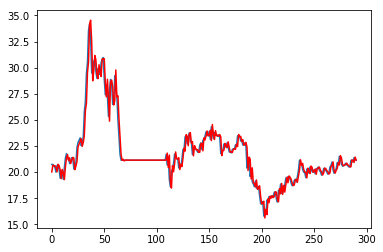

In [18]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()